In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator, MaxNLocator # added 
from tqdm import tqdm
from scipy import stats, interpolate
import yaml

from n3jet.general import FKSModelRun
from n3jet.utils.general_utils import dot


Bad key "legend.title_fontsize" on line 22 in
/mt/home/jbullock/.config/matplotlib/stylelib/notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## Set up

In [2]:
yaml_file = '/mt/home/jbullock/n3jet/n3jet/runs/runs/diphoton/3g2A/RAMBO/parallel_fixed/fks_all_legs_all_pairs_new_sherpa_cuts_pdf_njet.yaml'

In [3]:
save_dir = 'paper_plots/5_point/error_plots/unit_fks_RAMBO_100k_3M/'

## Data processing

In [4]:
test_fks_model = FKSModelRun.from_yaml(yaml_file, training=False)

/mt/home/jbullock/n3jet/n3jet/runs/runs/diphoton/3g2A/RAMBO/parallel_fixed/fks_all_legs_all_pairs_new_sherpa_cuts_pdf_njet.yaml


In [5]:
test_momenta, test_nj = test_fks_model.load_data()

############### Momenta loaded ###############
############### NJet loaded ###############
Training on 1000000 PS points


In [6]:
cut_momenta, near_momenta, cut_nj, near_nj, pairs, _, weights = test_fks_model.split_data(
    momenta = test_momenta, 
    nj = test_nj,
    return_weights = True
)

  2%|▏         | 1887/88451 [00:00<00:04, 18865.83it/s]

Pair 1 of 9


  3%|▎         | 2403/88451 [00:00<00:03, 24027.10it/s]

Pair 2 of 9


  3%|▎         | 2418/88451 [00:00<00:03, 24176.62it/s]

Pair 3 of 9


  3%|▎         | 2688/88451 [00:00<00:03, 26874.13it/s]

Pair 4 of 9


  2%|▏         | 1511/88451 [00:00<00:05, 14950.64it/s]

Pair 5 of 9


  3%|▎         | 2786/88451 [00:00<00:03, 27856.37it/s]

Pair 6 of 9


  2%|▏         | 2049/88451 [00:00<00:04, 20489.38it/s]

Pair 7 of 9


  2%|▏         | 2006/88451 [00:00<00:04, 20055.57it/s]

Pair 8 of 9


  2%|▏         | 1719/88451 [00:00<00:05, 17188.46it/s]

Pair 9 of 9


100%|██████████| 88451/88451 [00:03<00:00, 22607.11it/s]


In [7]:
cut_nj = np.array(cut_nj)
near_nj = np.array(near_nj)
total_nj = np.concatenate((cut_nj, near_nj))
total_momenta = np.concatenate((cut_momenta, near_momenta))

In [8]:
assert len(total_nj) == len(test_momenta)
assert len(total_momenta) == len(test_momenta)

test_points = len(test_momenta)
model_dir_new = test_fks_model.model_base_dir + test_fks_model.model_dir

In [9]:
nn_cut_all = []
nn_near_all = []
for t in tqdm(range(test_fks_model.training_reruns)):
    nn_cut = np.load(model_dir_new + '_{}/pred_cut_{}.npy'.format(t,test_points), allow_pickle=True)
    nn_near = np.load(model_dir_new + '_{}/pred_near_{}.npy'.format(t,test_points), allow_pickle=True)
    nn_cut_all.append(nn_cut)
    nn_near_all.append(nn_near)

nn_cut_std = np.std(nn_cut_all, ddof=1, axis=0)
nn_near_std = np.std(nn_near_all, ddof=1, axis=0)
    
nn_cut_mean = np.mean(nn_cut_all, axis=0)
nn_near_mean = np.mean(nn_near_all, axis=0)
    
assert len(nn_cut_mean) == len(cut_nj)
assert len(nn_near_mean) == len(near_nj)
    
total_nn = np.concatenate((nn_cut_mean, nn_near_mean))
total_nn_std = np.concatenate((nn_cut_std, nn_near_std))

assert len(total_nn) == test_points
assert len(total_nn_std) == test_points

100%|██████████| 20/20 [00:00<00:00, 177.89it/s]


## x_1 and x_2 RMSE

In [10]:
sq_errors = (total_nn - total_nj)**2

In [11]:
errors_sorted = np.argsort(sq_errors)

In [12]:
top_k_remove = 1

In [13]:
total_momenta = total_momenta[errors_sorted[:-top_k_remove]]
sq_errors = sq_errors[errors_sorted[:-top_k_remove]]

In [14]:
s_com = []
for i in total_momenta:
    s_com.append(np.sqrt(2*dot(i[0],i[1])))

In [15]:
s_com = np.array(s_com)

In [16]:
x_1 = total_momenta[:,0,0]/500.
x_2 = total_momenta[:,1,0]/500.

In [17]:
bins = np.arange(0,1.05,0.05)

In [18]:
counts, bins = np.histogram(x_1,bins=bins)
values, bins = np.histogram(x_1,weights=sq_errors,bins=bins)
norm_values = values/counts
norm_values[np.argwhere(np.isnan(norm_values))] = 0
norm_values = np.sqrt(norm_values)

/scratch/jbullock/venvs/n3jet-env-p2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
save_fig = 'x_1_error_plot'

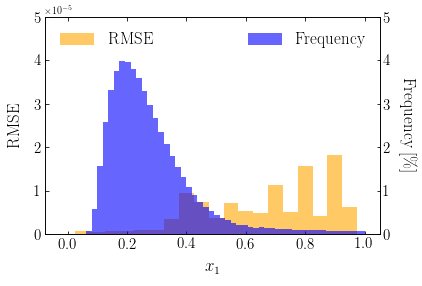

In [23]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax1 = plt.subplots()

ax1.bar(bins[:-1],norm_values,width=0.05, color='orange', alpha=0.6, label="RMSE")
ax1.set_ylabel(r'RMSE', fontsize=17, labelpad=10)
ax1.set_xlabel(r'$x_1$', fontsize=17, labelpad=10)
ax1.tick_params(axis='x', labelsize=15, direction = 'in', top = True)
ax1.tick_params(axis='y', labelsize=15, direction = 'in', right = True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2 = ax1.twinx()

ax2.hist(x_1,bins=50,density=True, color='blue', alpha=0.6, label="Frequency")
ax2.set_ylabel(r'Frequency [\%]', fontsize=17, labelpad=25, rotation=270)
ax2.tick_params(axis='y', labelsize=15, direction = 'in', right = True)
ax1.legend(prop={"size":17}, frameon = False, loc='upper left')
ax2.legend(prop={"size":17}, frameon = False, loc='upper right')

ax1.set_ylim((0,5e-5))
ax2.set_ylim((0,5))

plt.savefig(save_dir + save_fig + '.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
counts, bins = np.histogram(x_2,bins=bins)
values, bins = np.histogram(x_2,weights=sq_errors,bins=bins)
norm_values = values/counts
norm_values[np.argwhere(np.isnan(norm_values))] = 0
norm_values = np.sqrt(norm_values)

In [25]:
save_fig = 'x_2_error_plot'

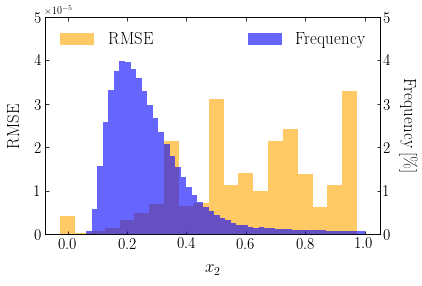

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax1 = plt.subplots()

ax1.bar(bins[:-1],norm_values,width=0.05, color='orange', alpha=0.6, label="RMSE")
ax1.set_ylabel(r'RMSE', fontsize=17, labelpad=10)
ax1.set_xlabel(r'$x_2$', fontsize=17, labelpad=10)
ax1.tick_params(axis='x', labelsize=15, direction = 'in', top = True)
ax1.tick_params(axis='y', labelsize=15, direction = 'in', right = True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2 = ax1.twinx()

ax2.hist(x_1,bins=50,density=True, color='blue', alpha=0.6, label="Frequency")
ax2.set_ylabel(r'Frequency [\%]', fontsize=17, labelpad=25, rotation=270)
ax2.tick_params(axis='y', labelsize=15, direction = 'in', right = True)
ax1.legend(prop={"size":17}, frameon = False, loc='upper left')
ax2.legend(prop={"size":17}, frameon = False, loc='upper right')

ax1.set_ylim((0,5e-5))
ax2.set_ylim((0,5))

plt.savefig(save_dir + save_fig + '.png', dpi=150, bbox_inches='tight')
plt.show()